# Relazione secondo progetto algoritmi avanzati

Francesca Meneghello 1227939 <br />
Leonardo Pratesi 1237582

## 1. Introduzione

scelta di utilizzare matrice per rappresentazione grafi

## 2. Algoritmo esatto di Held e Karp

In [14]:
import utilities as ut

#recursive version of the Held Karp algorithm
#receives a matrix of distances and returns the min circular path traversing al nodes once
def calcHeldKarpRecursiveVersion(dmatrix):
    dim = len(dmatrix)
    dist = {}
    py = {}   
    
    #recursive function to be called
    def HK_Visit(v, S):
        #print(v,encToList(S)) #Debug
        #case base
        if 1<<v == S:
            return dmatrix[0,v]

        #already calculated distance
        elif (v,S) in dist.keys():
            return dist[v,S]

        else:
            mindist = 2147483647
            minprec = -1

            prevsub = S & ~ (1 << v)
            listanodi = encToList(prevsub)

            for u in listanodi:
                distance = HK_Visit(u, prevsub)

                if distance + dmatrix[u,v] < mindist:
                    mindist = distance + dmatrix[u,v]
                    #print(v, encToList(S))
                    minprec = u
            
            dist[v,S] = mindist
            py[v,S] = minprec

            return mindist

    #support function that searches in py={} and reconstructs the whole path sequence
    def build_path():
        percorso = []
        k=0
        S=2**dim-1
        while len(percorso) < len(dmatrix)-1:
            temp = py[(k,S)]
            percorso.append(temp)
            S = S & ~ (1 << k)
            k = temp
        
        percorso.append(0)
        
        return percorso


    risultato = HK_Visit(0, 2**dim-1) #(1,V)
    #indexes were used 1 off so 1 add one to all so they represent the real nodes name
    #print(list(reversed(list(map(lambda x: x+1, build_path())))), risultato)
    return list(reversed(list(map(lambda x: x+1, build_path())))), risultato


#convert the binary encoding in the corresponding list
def encToList(binary):
    t = bin(binary)[2:]
    sett = []
    num=0
    for i in t[::-1]:
        if i == '1':
            sett.append(num)
        num += 1
    return sett

a = ut.parseFile('ulysses22.tsp')
print('heldkarp: ', calcHeldKarpRecursiveVersion(a))

{'NAME': 'ulysses22.tsp', 'TYPE': 'TSP', 'COMMENT': 'Odyssey of Ulysses (Groetschel/Padberg)', 'DIMENSION': '22', 'EDGE_WEIGHT_TYPE': 'GEO', 'DISPLAY_DATA_TYPE': 'COORD_DISPLAY'}
heldkarp:  ([1, 14, 13, 12, 7, 6, 15, 5, 11, 9, 10, 19, 20, 21, 16, 3, 2, 17, 22, 4, 18, 8], 7013)


## 3. Euristiche costruttive

### 3.1 Closest Insertion

In [13]:
import utilities as ut

def closestInsertion(dmatrix):
    #init
    dim = len(dmatrix)
    partial = []
    remaining = list(range(dim))

    #array that holds the path
    partial.append(0)
    #array that holds the remanining nodes
    remaining.remove(0)


    #stop the cicle when there are no more nodes to be added
    while remaining:

        toadd = -1
        mindist = 2147483647

        #get the node nearest to the partial graph
        for j in remaining:
            mindist2 = 2147483647
            for k in partial:
                if dmatrix[j,k] < mindist:
                    mindist2 = dmatrix[j,k]
            
            if mindist2 < mindist :
                toadd = j
                mindist = mindist2

        # remove the node that satisfies the condition of minimal distance
        remaining.remove(toadd)

        k = toadd
        pos = -1
        valnearest = 21474836474
        
        #find the correct position in which insert the node 
        if len(partial) == 1:
                nearest=1
        else:
            minimo=valnearest
            #dove inserire il nodo k dopo aver trovato la soluzione
            for i in range(0, len(partial)): #controllo le coppie di archi all'interno di C
                if i+1< len(partial):
                    val=dmatrix[partial[i],k] + dmatrix[k,partial[i+1]] - dmatrix[partial[i], partial[i+1]]
                    j=i+1
                else:
                    val=dmatrix[partial[i],k] + dmatrix[k,partial[0]] - dmatrix[partial[i], partial[0]]
                    j=0
                if val<minimo: 
                    minimo=val
                    pos=j


        #now i know what node i have to add (toadd) and where (pos)
        partial.insert(pos, toadd)
        
    #print(partial)      

    #compute total path length
    distanceFinal =0
    for i in range(len(partial)-1):
        distanceFinal += dmatrix[partial[i],partial[i+1]]
    #add the distance of the last elemento to the first element to complete the circle
    distanceFinal += dmatrix[0, partial[-1]]

    #as i worked with nodes starting from zero , i add one to all values so i get the real ones
    return list(map(lambda x:x+1,partial)), distanceFinal

a = ut.parseFile('ulysses22.tsp')
print('closest insertion: ', closestInsertion(a))


{'NAME': 'ulysses22.tsp', 'TYPE': 'TSP', 'COMMENT': 'Odyssey of Ulysses (Groetschel/Padberg)', 'DIMENSION': '22', 'EDGE_WEIGHT_TYPE': 'GEO', 'DISPLAY_DATA_TYPE': 'COORD_DISPLAY'}
closest insertion:  ([8, 18, 4, 22, 17, 2, 3, 16, 12, 21, 20, 19, 10, 9, 11, 7, 6, 13, 14, 5, 15, 1], 7735)


### 3.2 Farthest Insertion

In [7]:
import utilities as ut
import FarthestInsertion as fr #funzioni di supporto

def farthest(file_name):
    ############# LETTURA FILE ###############
    matrix=ut.parseFile(file_name)
    n=len(matrix)
    ############ VARIABILI ############
    C=[] #insieme di archi risultanti
    MAX= 9223372036854775807
    V=[] #insieme di tutti i nodi iniziali che vengono estratti man mano
    for i in range(0, n):
        V.append(i)
    ############# INIZIALIZZAZIONE ##################
    minimo= MAX
    j=-1
    for i in range(1, n):
        if matrix[0,i]<minimo:
            minimo=matrix[0,i]
            j=i
    #inserisco i primi due nodi nel circuito parziale
    C.append(0), C.append(j)
    #elimino i due nodi inseriti dall'insieme di tutti i vertici
    V.remove(0), V.remove(j)

    k=fr.selezione(V,C,matrix) #selezione del primo nodo k da inserire nel circuito parziale
    while k!=-1: #se ritorna -1 non ho più elementi da selezionare
        ########### INSERIMENTO #####################
        #arco {i, j} in C che minimizza matrix[i,k] + matrix[k,j] - matrix[i, j]
        minimo=MAX
        pos=-1 #dove inserire il nodo k dopo aver trovato la soluzione
        for i in range(0, len(C)): #controllo le coppie di archi all'interno di C
                if i+1< len(C):
                    val=matrix[C[i],k] + matrix[k,C[i+1]] - matrix[C[i], C[i+1]]
                    j=i+1
                else:
                    val=matrix[C[i],k] + matrix[k,C[0]] - matrix[C[i], C[0]]
                    j=0
                if val<minimo: 
                    minimo=val
                    pos=j
        V.remove(k) #elimino l'elemento K dall'insieme dei nodi ancora da estrarre
        C.insert(pos, k) #inserisco K tra i e j nel circuito parziale C
        k=fr.selezione(V,C,matrix)
        
    totale=fr.calcTot(C, matrix)
    return C, totale #return ciclo e soluzione finale

ciclo, tot= farthest('burma14.tsp')
fr.printCycle(ciclo)
print(tot)

{'NAME': 'burma14', 'TYPE': 'TSP', 'COMMENT': '14-Staedte in Burma (Zaw Win)', 'DIMENSION': '14', 'EDGE_WEIGHT_TYPE': 'GEO', 'EDGE_WEIGHT_FORMAT': 'FUNCTION', 'DISPLAY_DATA_TYPE': 'COORD_DISPLAY'}
11 9 10 1 2 14 3 4 5 6 12 7 13 8 
3323


## 4. Algoritmo 2-approssimato

In [2]:
import utilities as ut
import approx as ap #funzioni di supporto
import Prim as pr #funzioni per il calcolo dell'mst con algortmo di Prim

def approx(file_name, root):

    mst, matrix= pr.Prim(file_name, root) 
    n= len(mst)
    
    #aggiungi lista figli
    for i in range(0, n):
        if mst[i].pi!=None:
            r=int(mst[i].pi)
            mst[r].child.append(i)
            
    H=[]
    ap.Preorder(mst, root, H)

    total=0
    #calcolo costo totale
    for i in range(0, n-1):
        total+= matrix[H[i], H[i+1]]
    #aggiunta ultimo arco
    total+= matrix[H[n-1], H[0]]

    return H, total

H, total= approx('burma14.tsp', 0) #parte dal nodo 1 del grafo che nella nostra codifica è 0
ap.printH(H)
print(total)

burma14.tsp
{'NAME': 'burma14', 'TYPE': 'TSP', 'COMMENT': '14-Staedte in Burma (Zaw Win)', 'DIMENSION': '14', 'EDGE_WEIGHT_TYPE': 'GEO', 'EDGE_WEIGHT_FORMAT': 'FUNCTION', 'DISPLAY_DATA_TYPE': 'COORD_DISPLAY'}
1 2 8 11 9 10 13 7 12 4 6 5 14 3 
4003


## 5. Tabella

<img src="Tabella.png" width=850 height=800 />

## 6. Conclusioni

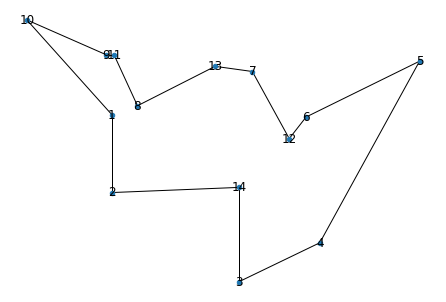

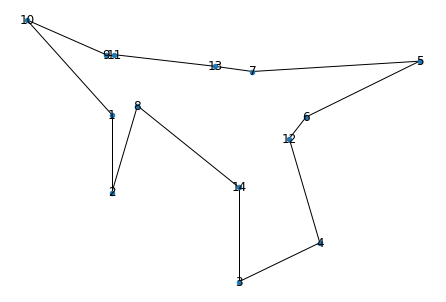

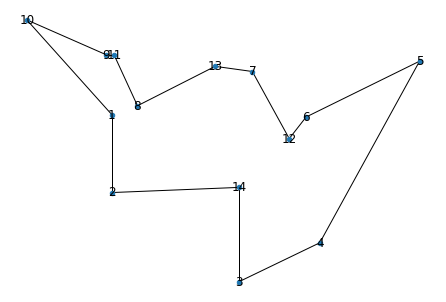

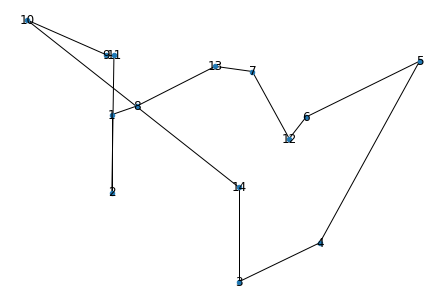

In [7]:
#burma
import DrawingTest as draw
pathburmafarthest = [11,9,10,1,2,14,3,4,5,6,12,7,13,8]
pathburmaclosest = [2, 8, 14, 3, 4, 12, 6, 5, 7, 13, 11, 9, 10, 1] #closestInsertion('burma14.tsp')[0]
pathburmaheld = [1, 10, 9, 11, 8, 13, 7, 12, 6, 5, 4, 3, 14, 2] #calcHeldKarpRecursiveVersion('burma14.tsp')[0]
path2approx = [5,6,12,7,13,8,1,2,11,9,10,14,3,4]
draw.drawPath('burma14.tsp', pathburmafarthest)
draw.drawPath('burma14.tsp', pathburmaclosest)
draw.drawPath('burma14.tsp', pathburmaheld)
draw.drawPath('burma14.tsp', path2approx)



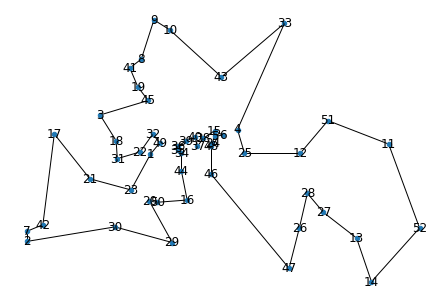

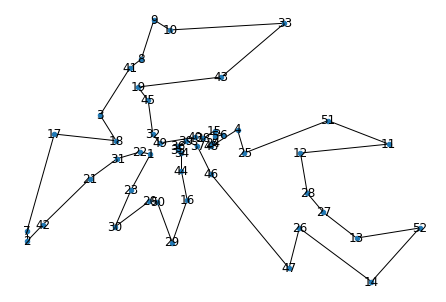

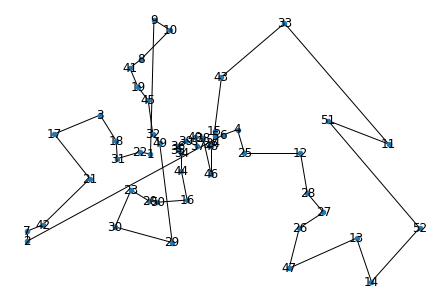

In [9]:
#berlin52 no held
import DrawingTest as draw
pathberlinfarth = [32,49,1,23,21,17,42,7,2,30,29,20,50,16,44,34,35,36,39,40,37,38,15,6,5,24,48,46,47,26,28,27,13,14,52,11,51,12,25,4,33,43,10,9,8,41,19,45,3,18,31,22]
pathberlinclos = [22, 31, 21, 42, 2, 7, 17, 18, 3, 41, 8, 9, 10, 33, 43, 19, 45, 32, 49, 40, 38, 15, 6, 5, 24, 48, 4, 25, 51, 11, 12, 28, 27, 13, 52, 14, 26, 47, 46, 37, 39, 36, 35, 34, 44, 16, 29, 50, 20, 30, 23, 1]
path2approxberlin = [33,43,15,5,24,48,46,38,40,37,39,36,35,34,44,16,50,20,23,30,29,49,32,45,19,41,8,10,9,1,22,31,18,3,17,21,42,7,2,6,4,25,12,28,27,26,47,13,14,52,51,11]
draw.drawPath('berlin52.tsp', pathberlinfarth)
draw.drawPath('berlin52.tsp', pathberlinclos)
draw.drawPath('berlin52.tsp', path2approxberlin)

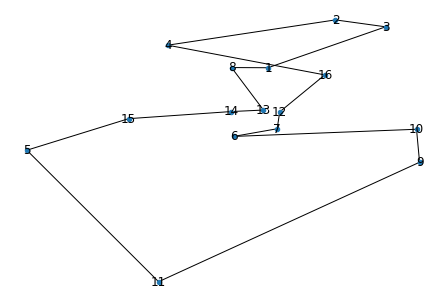

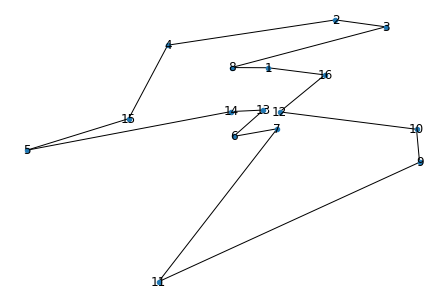

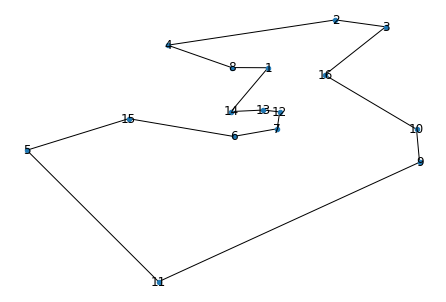

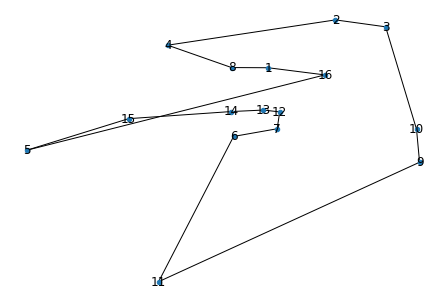

In [12]:
#ulysees16
import DrawingTest as draw
farth = [1,3,2,4,16,12,7,6,10,9,11,5,15,14,13,8]
clos = [8, 3, 2, 4, 15, 5, 14, 13, 6, 7, 11, 9, 10, 12, 16, 1]
held = [1, 14, 13, 12, 7, 6, 15, 5, 11, 9, 10, 16, 3, 2, 4, 8]
twoapprox = [6,7,12,13,14,15,5,16,1,8,4,2,3,10,9,11]

draw.drawPath('ulysses16.tsp', farth)
draw.drawPath('ulysses16.tsp', clos)
draw.drawPath('ulysses16.tsp', held)
draw.drawPath('ulysses16.tsp', twoapprox)

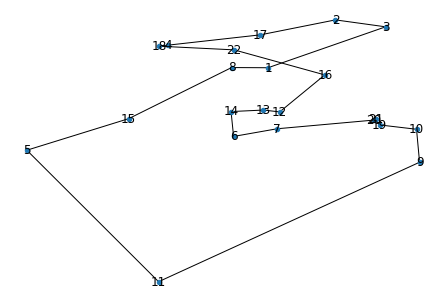

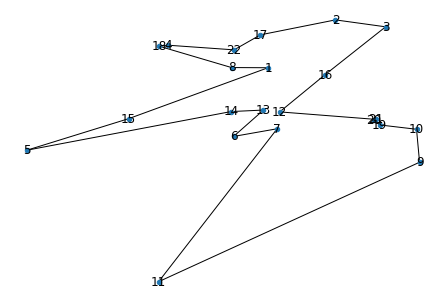

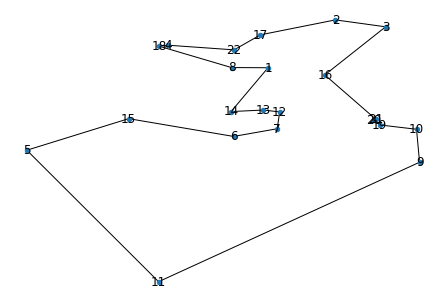

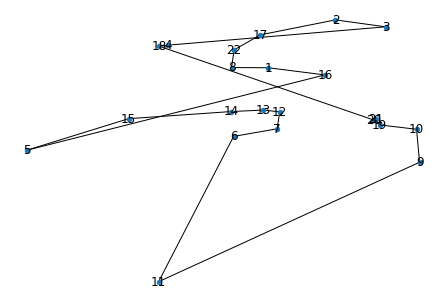

In [16]:
#ulysses22
import DrawingTest as draw
farth = [1,3,2,17,4,18,22,16,12,13,14,6,7,20,21,19,10,9,11,5,15,8]
clos = [8, 18, 4, 22, 17, 2, 3, 16, 12, 21, 20, 19, 10, 9, 11, 7, 6, 13, 14, 5, 15, 1]
held = [1, 14, 13, 12, 7, 6, 15, 5, 11, 9, 10, 19, 20, 21, 16, 3, 2, 17, 22, 4, 18, 8]
twoapprox = [6,7,12,13,14,15,5,16,1,8,22,17,2,3,4,18,20,21,19,10,9,11]

draw.drawPath('ulysses22.tsp', farth)
draw.drawPath('ulysses22.tsp', clos)
draw.drawPath('ulysses22.tsp', held)
draw.drawPath('ulysses22.tsp', twoapprox)